## Model Selection and Putting it all together

*a priori* we do not know which model will perform the best. Depending on the data, simple models (such as linear regression) may be the most performant, while for other data, complex deep learning algorithms. It is important to note, THE MOST COMPLEX ALGORITHM IS NOT ALWAYS THE BEST PERFORMING. As a result, multiple models are tested initially and their performance evaluated. The top performing (or top n performing) are then down selected for more significant optimization. 

In [8]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, accuracy_score, \
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [9]:
RootDir = '/Users/ggray15/src/python/repos/jhach_cpdsam_symposium_workshop'
os.chdir(RootDir)

In [10]:
%run "./notebooks/common/function_library.ipynb"

In [11]:
train_impute = pd.read_csv('data/train_smote.csv')
test_impute = pd.read_csv('data/test_impute.csv')

In [12]:
train_features = train_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_train = train_impute[train_features]
X_test = test_impute[train_features]
y_train = train_impute[target_feature]
y_test = test_impute[target_feature]

In [13]:
# Json files containig hyperparameters. 
param_files = [
    'lr_params.json',
    'knn_params.json',
    'svm_params.json',
    'mlp_params.json',
    'rf_params.json',
    'gb_params.json',
]

param_dict = dict()

for iFile in param_files:
    iKey = iFile.split('_')[0]
    with open(os.path.join('input',iFile),'r') as f:
        params = json.load(f)
        param_dict[iKey] = BuildSamplingDict(params)

### Model Types 

Many different models exist for machine learning and deep learning applications, with new architectures being developed and released every day. Below, we test some of the most common models, which are briefly outlined and explained below.

#### Logistic Regression

Perhaps one of the best known models, logistic regression fits a first order polynomial with parameters for each feature, which constitute the weight to the prediction output. Non-linearity can be introduced by fitting to a polynomial of degree n. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### K-Nearest Neighbors

An unsupervised learning approach, data is ordered into multiple clusters corresponding to different classes using some specified metric (often distance). New preidctions can be made by finding the cluster closest in distance to the data point of interest.  

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Support Vector Machine

Support vector machines work by drawing boundaries between different classes in the subspace of features. This effectively separates the classes into different subspaces, allowing predictions of new features by identifying which subspace they are present in.

For more see https://scikit-learn.org/stable/modules/svm.html

#### Multi-layer Perceptron

A simple neural network, this multilayer perceptron model is comprised of an input layer, single hidden layer and output layer. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

#### Random Forest

Previosly described, an ensemble method leveraging multiple decision trees

For more see https://scikit-learn.org/stable/modules/svm.html

#### Gradient Boosting

Another ensemble method using tree-based methods. The primary distinction is the incorporation of coefficients to fit the trees to the residuals (errors). This allows the model to focus on classes that is makes more mistakes

For more see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [14]:
estimator_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=1000),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier()
}

In [15]:
model_dict = dict()

for iKey in estimator_dict:

    print(f'##### Now processing model {iKey} #####')

    model_dict[iKey] = TuneHyperParameters(
        X_train=X_train, y_train=y_train, estimator=estimator_dict[iKey],param_dict=param_dict[iKey])
    
    test_score = EvaluateModel(X_test=X_test,y_test=y_test,estimator=model_dict[iKey])
    print(f'  > Test score was {test_score}')   

##### Now processing model lr #####
  > Test score was 0.5093264133785792
##### Now processing model knn #####
  > Test score was 0.5681238494466254
##### Now processing model svm #####


/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ggray15/opt/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  > Test score was 0.6093626396374417
##### Now processing model mlp #####
  > Test score was 0.5616031228513763
##### Now processing model rf #####
  > Test score was 0.5939184243795329
##### Now processing model gb #####
  > Test score was 0.6617280664788815


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


##### Now processing model lr #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9382716049382716
F1 Score: 0.013157894736842106
AUC: 0.5093264133785792
Precision: 0.010526315789473684
Recall: 0.017543859649122806
logloss: 2.224916875871429
PPV: 0.010526315789473684
NPV: 0.976017130620985
True Negative: 2279
False Positive: 94
False Negative: 56
True Positive: 1
##### Now processing model knn #####
Accuracy: 0.8395061728395061
F1 Score: 0.0625
AUC: 0.5681238494466254
Precision: 0.036211699164345405
Recall: 0.22807017543859648
logloss: 5.784783877265716
PPV: 0.036211699164345405
NPV: 0.9787542250120714
True Negative: 2027
False Positive: 346
False Negative: 44
True Positive: 13
##### Now processing model svm #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.897119341563786
F1 Score: 0.05303030303030303
AUC: 0.6093626396374416
Precision: 0.033816425120772944
Recall: 0.12280701754385964
logloss: 3.7081947931190484
PPV: 0.033816425120772944
NPV: 0.9775078722447144
True Negative: 2173
False Positive: 200
False Negative: 50
True Positive: 7
##### Now processing model mlp #####
Accuracy: 0.8995884773662551
F1 Score: 0.06870229007633588
AUC: 0.5616031228513763
Precision: 0.04390243902439024
Recall: 0.15789473684210525
logloss: 3.6191981180841912
PPV: 0.04390243902439024
NPV: 0.9784269662921349
True Negative: 2177
False Positive: 196
False Negative: 48
True Positive: 9
##### Now processing model rf #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8872427983539095
F1 Score: 0.06164383561643836
AUC: 0.5939184243795329
Precision: 0.03829787234042553
Recall: 0.15789473684210525
logloss: 4.064181493258477
PPV: 0.03829787234042553
NPV: 0.9781321184510251
True Negative: 2147
False Positive: 226
False Negative: 48
True Positive: 9
##### Now processing model gb #####
Accuracy: 0.8748971193415638
F1 Score: 0.08982035928143713
AUC: 0.6617280664788815
Precision: 0.05415162454873646
Recall: 0.2631578947368421
logloss: 4.509164868432764
PPV: 0.05415162454873646
NPV: 0.9804923362749651
True Negative: 2111
False Positive: 262
False Negative: 42
True Positive: 15


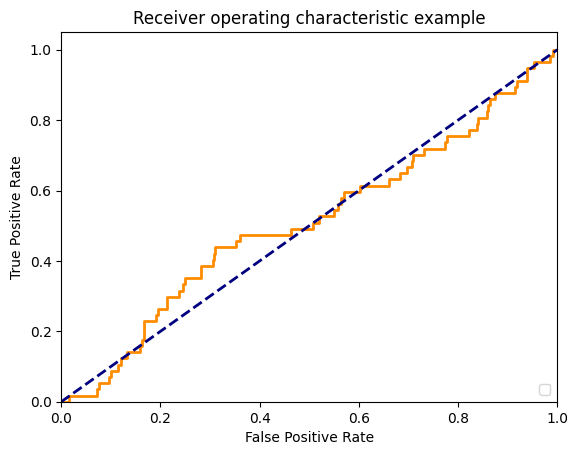

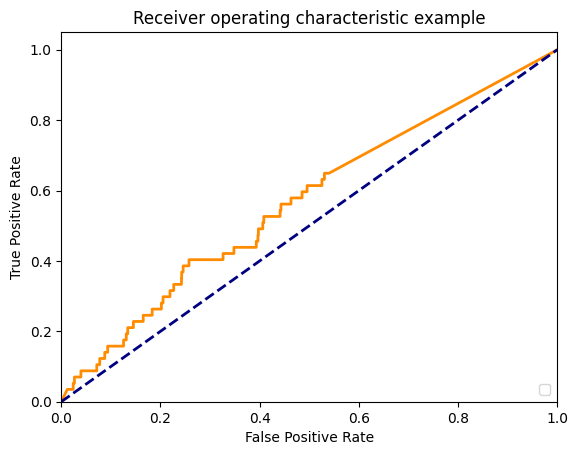

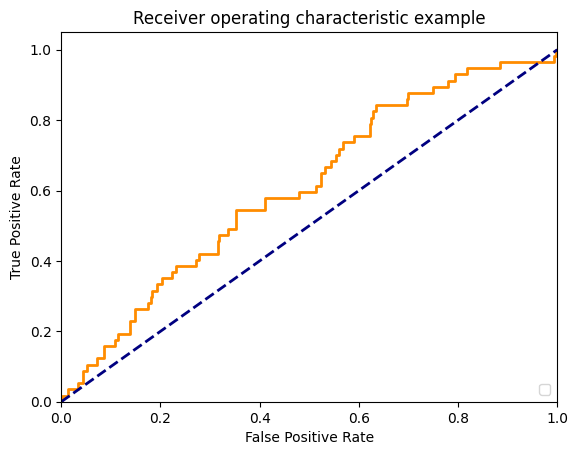

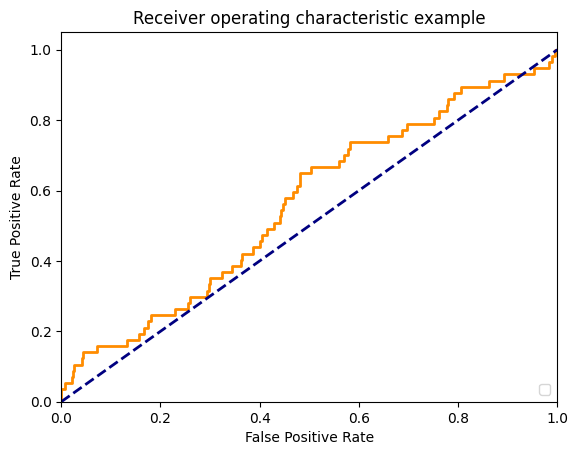

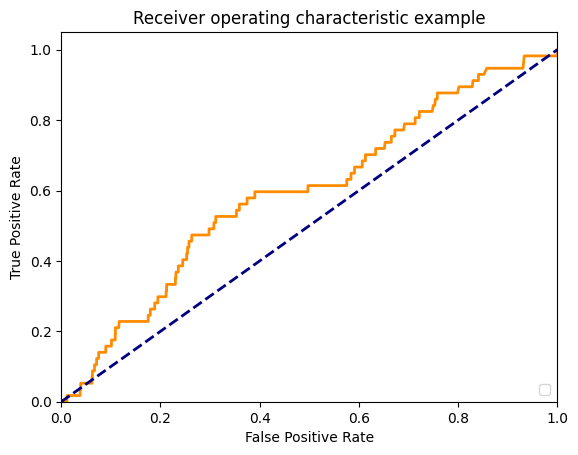

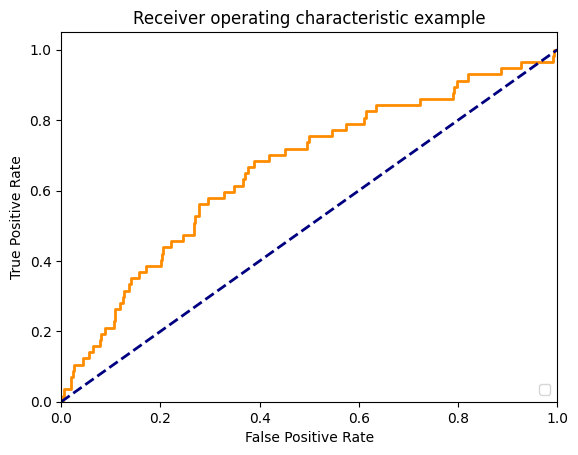

In [16]:
for iKey in model_dict:

    print(f'##### Now processing model {iKey} #####')
    LogMetrics(model_dict[iKey],X_test, y_test)

In [17]:
iKey = 'gb'
filename = 'data/best_model_'+iKey+'.sav'
joblib.dump(model_dict[iKey], filename)

['data/best_model_gb.sav']